# Project

In [1]:
import numpy as np

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
sns.set_context("paper", font_scale=2)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [4]:
TEST_DATASET_PATH = 'test.csv'
TRAIN_DATASET_PATH = 'train.csv'

In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, index_col = 'Id')
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,nan,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [6]:
df_test = pd.read_csv(TEST_DATASET_PATH, index_col = 'Id')
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,nan,0,0,B
15856,74,2.00,69.26,nan,1.00,6,1.00,1977,0.08,B,B,6,1437,3,nan,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,nan,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,nan,0,0,A


In [7]:
df_test.shape, df_train.shape

((5000, 18), (10000, 19))

In [8]:
df_train.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

# Обзор данных

Распределение значений целевой переменной

Text(0.5, 1.0, 'Price')

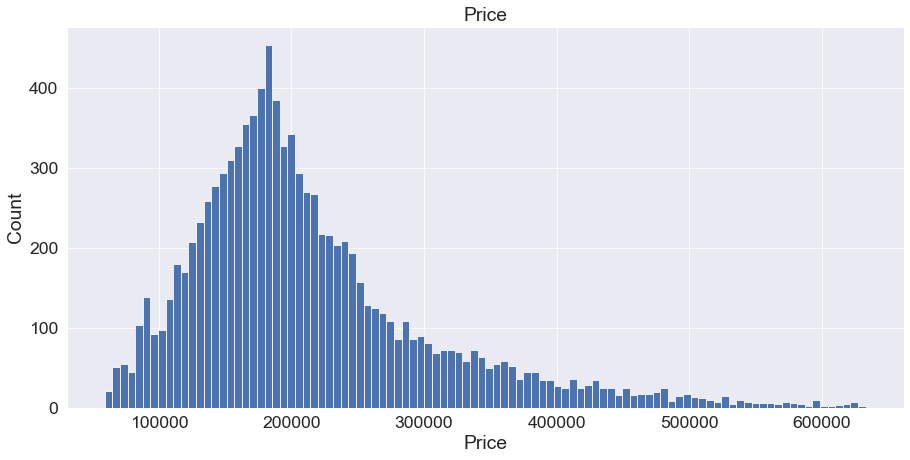

In [10]:
plt.figure(figsize = (15,7))
df_train['Price'].hist(bins = 100)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price')

Определение встречаемости уникальных ненулевых значений

In [11]:
df_train.nunique()

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [12]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [13]:
df_test.nunique()

DistrictId        201
Rooms               8
Square           5000
LifeSquare       3959
KitchenSquare      38
Floor              35
HouseFloor         41
HouseYear          97
Ecology_1         130
Ecology_2           2
Ecology_3           2
Social_1           51
Social_2          143
Social_3           30
Healthcare_1       79
Helthcare_2         7
Shops_1            16
Shops_2             2
dtype: int64

# Категориальные переменные

In [14]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [17]:
df_train['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

Перевод в бинарный вид

In [18]:
feature_bin = ['Ecology_2', 'Ecology_3', 'Shops_2']

df_train[feature_bin] = df_train[feature_bin].replace({'A':0, 'B':1})
df_test[feature_bin] = df_test[feature_bin].replace({'A':0, 'B':1})

# Обработка пропусков

In [19]:
df_train.isna().sum()[df_train.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

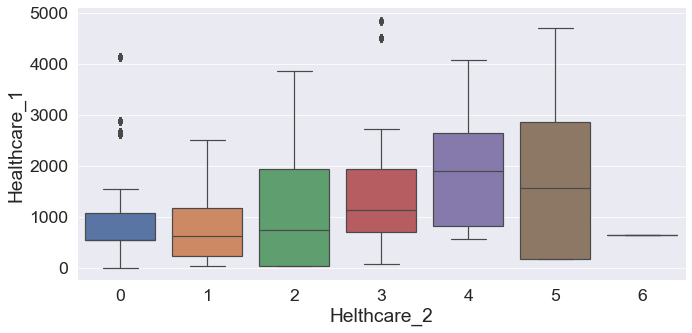

In [20]:
sns.catplot('Helthcare_2', 'Healthcare_1', kind="box", data=df_train, aspect=2/1)

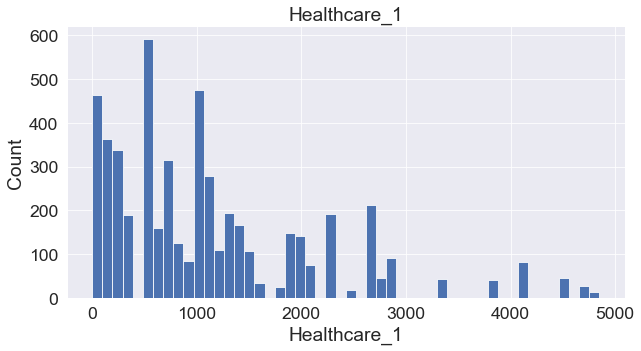

In [21]:
plt.figure(figsize = (10, 5))

df_train['Healthcare_1'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Healthcare_1')
plt.title('Healthcare_1');

Healthcare_1

In [22]:
df_train['Healthcare_1'].fillna(df_train['Healthcare_1'].median(), inplace=True)
df_test['Healthcare_1'].fillna(df_train['Healthcare_1'].median(), inplace=True)

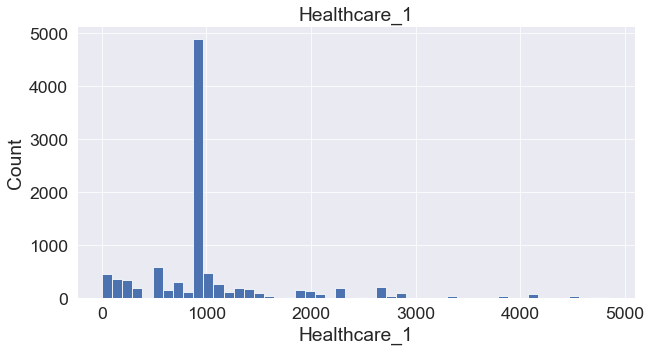

In [23]:
plt.figure(figsize = (10, 5))

df_train['Healthcare_1'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Healthcare_1')
plt.title('Healthcare_1');

In [24]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,0.99,0.97,24.69,"5,352.16",8.04,"1,026.36",1.32,4.23,0.92,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,0.10,0.16,17.53,"4,006.80",23.83,746.66,1.49,4.81,0.28,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,1.00,1.00,6.00,"1,564.00",0.00,830.00,0.00,1.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,1.00,1.00,25.00,"5,285.00",2.00,900.00,1.00,3.00,1.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,1.00,1.00,36.00,"7,227.00",5.00,990.00,2.00,6.00,1.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,1.00,1.00,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,1.00,"633,233.47"


LifeSquare

In [25]:
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare'] = \
    df_train['Square'] * df_train['LifeSquare'].median() / df_train['Square'].median()
df_test.loc[df_test['LifeSquare'].isna(), 'LifeSquare'] = \
    df_test['Square'] * df_train['LifeSquare'].median() / df_train['Square'].median()

In [26]:
df_train.isna().sum()[df_train.isna().sum() != 0]

Series([], dtype: int64)

In [27]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.30,6.27,8.53,12.61,"3,990.17",0.12,0.99,0.97,24.69,"5,352.16",8.04,"1,026.36",1.32,4.23,0.92,"214,138.86"
std,0.84,21.06,76.87,28.56,5.24,6.78,"200,500.26",0.12,0.10,0.16,17.53,"4,006.80",23.83,746.66,1.49,4.81,0.28,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,24.35,1.00,4.00,9.00,"1,974.00",0.02,1.00,1.00,6.00,"1,564.00",0.00,830.00,0.00,1.00,1.00,"153,872.63"
50%,2.00,52.51,33.29,6.00,7.00,13.00,"1,977.00",0.08,1.00,1.00,25.00,"5,285.00",2.00,900.00,1.00,3.00,1.00,"192,269.64"
75%,2.00,65.90,44.93,9.00,12.00,17.00,"2,001.00",0.20,1.00,1.00,36.00,"7,227.00",5.00,990.00,2.00,6.00,1.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,1.00,1.00,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,1.00,"633,233.47"


# Обработка выбросов

Rooms

In [28]:
df_train['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

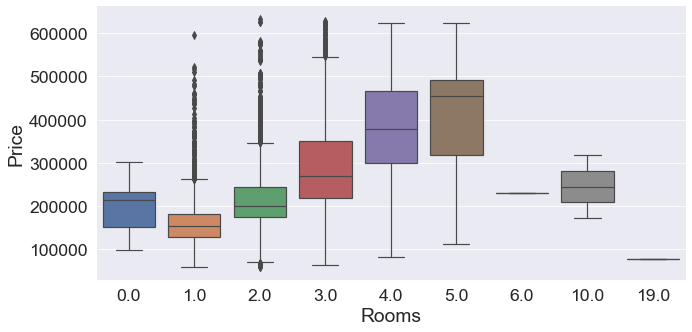

In [29]:
sns.catplot('Rooms', 'Price', kind="box", data=df_train, aspect=2/1)

In [30]:
df_train.loc[(df_train['Rooms'] > 5)|(df_train['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].mode()[0]
df_test.loc[(df_test['Rooms'] > 5)|(df_test['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].mode()[0]

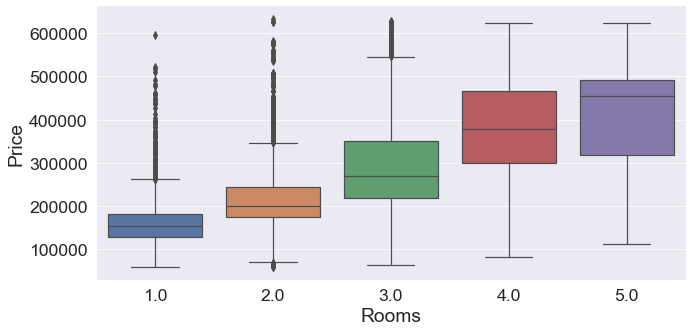

In [31]:
sns.catplot('Rooms', 'Price', kind="box", data=df_train, aspect=2/1)

all Square

In [32]:
df_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.32,37.30,6.27
std,21.06,76.87,28.56
min,1.14,0.37,0.00
25%,41.77,24.35,1.00
50%,52.51,33.29,6.00
75%,65.90,44.93,9.00
max,641.07,"7,480.59","2,014.00"


In [33]:
df_train['KitchenSquare'].value_counts()

1.00        2460
8.00        1306
5.00        1169
10.00       1075
6.00        1038
9.00         843
0.00         697
7.00         609
12.00        249
11.00        233
13.00         67
14.00         51
4.00          39
15.00         31
3.00          22
16.00         16
20.00         14
17.00         12
19.00         11
18.00          6
2.00           4
22.00          3
41.00          2
112.00         2
25.00          2
43.00          2
51.00          2
37.00          2
32.00          2
30.00          2
58.00          2
72.00          1
96.00          1
66.00          1
48.00          1
40.00          1
2,014.00       1
35.00          1
60.00          1
78.00          1
27.00          1
84.00          1
62.00          1
42.00          1
63.00          1
39.00          1
1,970.00       1
36.00          1
75.00          1
26.00          1
21.00          1
29.00          1
23.00          1
73.00          1
123.00         1
31.00          1
53.00          1
54.00          1
Name: KitchenS

In [34]:
df_train.loc[(df_train['KitchenSquare'] > 40) | \
             (df_train['KitchenSquare'] > df_train['Square']),
             'KitchenSquare'] = df_train['KitchenSquare'].median()

df_test.loc[(df_test['KitchenSquare'] > 40) | \
            (df_test['KitchenSquare'] > df_test['Square']),
            'KitchenSquare'] = df_train['KitchenSquare'].median()

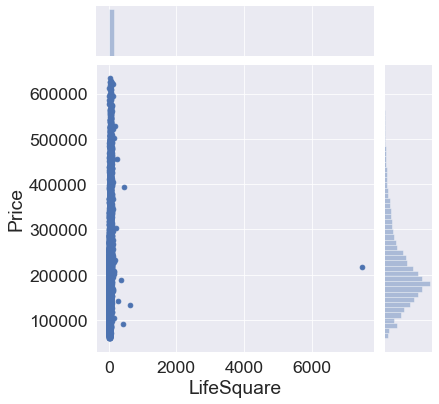

In [35]:
sns.jointplot(df_train['LifeSquare'], df_train['Price'], kind='scatter', height=6)

In [36]:
df_train.loc[(df_train['LifeSquare'] > 350), 'LifeSquare'] = \
        df_train['LifeSquare'].median()
df_test.loc[(df_test['LifeSquare'] > 350), 'LifeSquare'] = \
        df_train['LifeSquare'].median()

In [37]:
df_train.loc[(df_train['Square'] > 300) | (df_train['Square'] < 25), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.00,5.50,67.63,1.00,24,22.00,1977,0.13,1,1,43,8429,3,900.00,3,9,1,"412,511.09"
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,1,1,4,915,0,900.00,0,0,1,"107,604.27"
1775,101,1.00,23.58,18.44,3.00,3,5.00,1968,0.23,0,1,41,6558,7,"1,548.00",3,2,1,"108,232.65"
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,1,1,5,1564,0,540.00,0,0,1,"137,597.60"
13685,0,1.00,17.50,13.45,0.00,7,5.00,1961,0.32,1,1,25,4756,16,"2,857.00",5,8,1,"88,871.75"
3732,112,1.00,20.21,13.80,3.00,5,9.00,1974,0.07,1,1,31,6119,4,900.00,1,2,1,"113,050.23"
15127,150,1.00,17.05,20.04,8.00,7,12.00,1982,0.30,1,1,52,10311,6,900.00,1,9,1,"74,222.11"
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,1,1,9,1892,0,900.00,0,1,1,"97,560.72"
9487,5,1.00,5.13,5.55,1.00,1,1.00,1977,0.15,1,1,16,3433,4,"2,643.00",4,5,1,"369,472.40"


In [38]:
df_train.loc[(df_train['Square'] > 400) | (df_train['Square'] < 20), 'Square'] = \
            df_train['Square'].median()

df_test.loc[(df_test['Square'] > 400) | (df_test['Square'] < 10), 'Square'] = \
            df_train['Square'].median()

In [39]:
len(df_train[(df_train['Square'] < df_train['LifeSquare'] + df_train['KitchenSquare'])])

822

In [40]:
df_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.26,36.38,5.73
std,19.03,16.96,4.04
min,20.21,0.37,0.00
25%,41.81,24.35,1.00
50%,52.51,33.29,6.00
75%,65.89,44.90,9.00
max,275.65,263.54,40.00


Floor

In [41]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [42]:
df_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [43]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].mode()[0]
df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].mode()[0]

In [44]:
floor_outliers_train = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
floor_outliers_test = df_test.loc[df_test['Floor'] > df_test['HouseFloor']].index

floor_outliers_train

Int64Index([10953,  2119, 11935,  6486, 10521, 10103,  8443,  1063, 14675,
            14020,
            ...
            10361,  4660, 16050, 12590,  5071,  2237, 16159,  4145, 11553,
               77],
           dtype='int64', name='Id', length=1578)

In [45]:
df_train.loc[floor_outliers_train, 'Floor'] = \
    df_train.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
df_test.loc[floor_outliers_test, 'Floor'] = \
    df_test.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

HouseYear

In [46]:
df_train['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
6731         2020
8892         2020
14318        2020
           ...   
7920         1916
6751         1914
2085         1912
14556        1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [47]:
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = 2011

# Новые признаки

PricePerM2

In [48]:
df_train['PricePerM2'] = df_train['Price'] / df_train['Square']

In [49]:
df_train['PricePerM2'].describe()

count   10,000.00
mean     3,888.65
std      1,250.75
min        752.59
25%      2,914.73
50%      3,904.25
75%      4,689.59
max     11,854.65
Name: PricePerM2, dtype: float64

PricePerM2ByDistrict

In [50]:
price_by_district = df_train.groupby(['DistrictId'], as_index=False)\
                        .agg({'PricePerM2':'median'})\
                        .rename(columns={'PricePerM2':'PricePerM2ByDistrict'})

price_by_district

,DistrictId,PricePerM2ByDistrict
0,0,"3,721.97"
1,1,"3,251.65"
2,10,"4,458.89"
3,100,"4,933.39"
4,101,"4,185.96"
...,...,...
200,95,"5,496.39"
201,96,"4,025.34"
202,97,"4,942.57"
203,98,"4,444.98"


In [51]:
df_train = df_train.merge(price_by_district, on=['DistrictId'], how='left').set_index(df_train.index)
df_test = df_test.merge(price_by_district, on=['DistrictId'], how='left').set_index(df_test.index)

In [52]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,PricePerM2,PricePerM2ByDistrict
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,...,33,7976,5,900.00,0,11,1,"184,966.93","3,854.96","4,358.27"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,...,46,10309,1,240.00,1,16,1,"300,009.45","4,567.49","4,437.30"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,...,34,7759,0,229.00,1,3,1,"220,925.91","4,915.15","4,845.92"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,...,23,5735,3,"1,084.00",0,5,1,"175,616.23","3,291.59","2,949.98"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,...,35,5776,1,"2,078.00",2,4,1,"150,226.53","3,788.89","3,992.03"


In [53]:
df_test.count()

DistrictId              5000
Rooms                   5000
Square                  5000
LifeSquare              5000
KitchenSquare           5000
Floor                   5000
HouseFloor              5000
HouseYear               5000
Ecology_1               5000
Ecology_2               5000
Ecology_3               5000
Social_1                5000
Social_2                5000
Social_3                5000
Healthcare_1            5000
Helthcare_2             5000
Shops_1                 5000
Shops_2                 5000
PricePerM2ByDistrict    4992
dtype: int64

In [54]:
df_train.count()

DistrictId              10000
Rooms                   10000
Square                  10000
LifeSquare              10000
KitchenSquare           10000
Floor                   10000
HouseFloor              10000
HouseYear               10000
Ecology_1               10000
Ecology_2               10000
Ecology_3               10000
Social_1                10000
Social_2                10000
Social_3                10000
Healthcare_1            10000
Helthcare_2             10000
Shops_1                 10000
Shops_2                 10000
Price                   10000
PricePerM2              10000
PricePerM2ByDistrict    10000
dtype: int64

In [55]:
df_test.isna().sum()[df_test.isna().sum() != 0]

PricePerM2ByDistrict    8
dtype: int64

In [56]:
df_test['PricePerM2ByDistrict'].fillna(df_train['PricePerM2ByDistrict'].median(), inplace=True)

# Отбор признаков

In [57]:
df_train.to_csv('prepared_train.csv')
df_test.to_csv('prepared.csv')

In [58]:
feature_names = df_train.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'PricePerM2',
 'PricePerM2ByDistrict']

In [59]:
target_name = ['Price']
feature_names = [
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 #'Ecology_2',
 #'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 #'Shops_2',
 #'PricePerM2'
 'PricePerM2ByDistrict'
 #'Price'
                ]

In [60]:
X = df_train[feature_names]
y = df_train[target_name]

X_test = df_test[feature_names]

In [61]:
forest = RandomForestRegressor(max_depth=18, 
                               max_features=5, 
                               n_estimators=500,
                               random_state=42)

In [62]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.75971


# Оценка признаков

In [63]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

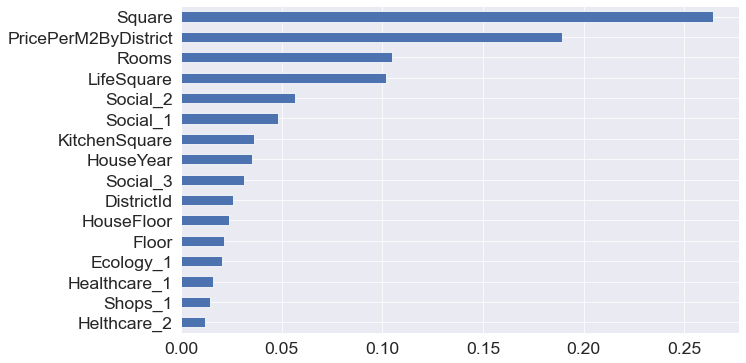

In [64]:
feat_importances.plot(kind='barh', figsize=(10, 6));

# Настройка гиперпараметров

In [65]:
params = {
    'n_estimators': [400],
    'max_depth': [18,19,20],
    'max_features': [5,6,7]
}

In [66]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

{'max_depth': 18, 'max_features': 6, 'n_estimators': 400}
R2 на train: 0.76173


# Прогноз

In [67]:
forest_best = forest_grid.best_estimator_

y_pred = forest_best.predict(X_test)

In [68]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"156,362.06"
1,15856,"222,425.61"
2,5480,"272,250.46"
3,15664,"304,251.55"
4,14275,"147,242.66"


In [69]:
preds.to_csv('IBeloded_preds.csv', index=False)